In [29]:
library(tidyverse)
#install.packages('hexbin')
#library(nycflights13)
library(broom)
library(hexbin)
library(modelr)  
library(gridExtra)

options(repr.plot.width=5, repr.plot.height=3)

In [30]:
### CONFOUNDER
# Niedrigere Qualität mit hohem Preis aufgrund des Confounders Gewicht = carat
# => carat wichtigster Predictor für Preis 
# => low-quality diamonds sind meist schwerer
#
# Ziel: Rausseparieren des Effekts von carat um Effekt von anderne Variablen sichtbar zu machen

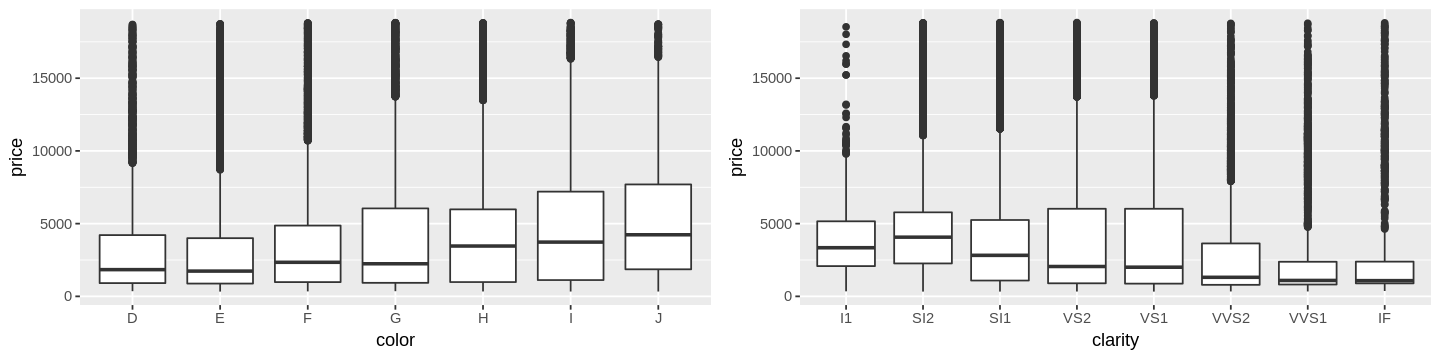

In [31]:
### Untersuchen der Zusammenhänge mit Boxplots
#ggplot(diamonds, aes(cut, price)) + geom_boxplot()
options(repr.plot.width=12, repr.plot.height=3)
p1 <- ggplot(diamonds, aes(color, price)) + geom_boxplot()
p2 <- ggplot(diamonds, aes(clarity, price)) + geom_boxplot()
grid.arrange(p1, p2, ncol=2)

# => Überraschend: 
#    Diamanten mit niedrigerer Qualität haben hohe Preise
#    => z.B  SCHLECHTESTE Farbe J und SCHLECHTESTE clarity l1 (links!) haben HÖCHSTEN PREIS?!
# ==> confounding (durch carat)

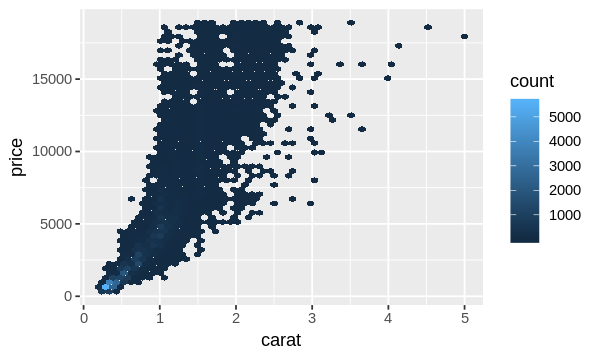

In [36]:
### Vorbereitung: Transformation

## Hexplot statt Scatterplot bei vielen Observations
options(repr.plot.width=5, repr.plot.height=3)
ggplot(diamonds, aes(carat, price)) + geom_hex(bins = 50)

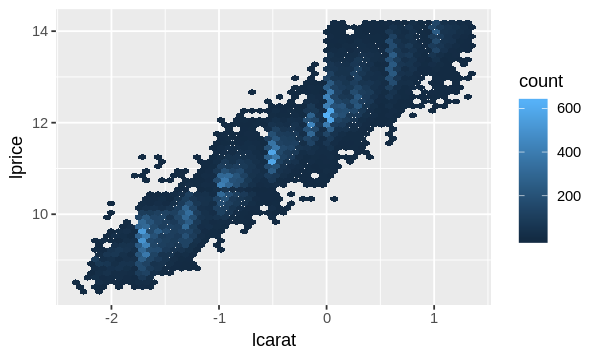

In [37]:
# Vorverarbeiten der Daten um Zusammenhang von price und carat besser untersuchen zu können
diamonds2 <- diamonds %>%
  filter(carat <= 2.5) %>%
  mutate(lprice = log2(price), lcarat = log2(carat))

ggplot(diamonds2, aes(lcarat, lprice)) +
  geom_hex(bins = 50)
# => lineare Muster - besser!

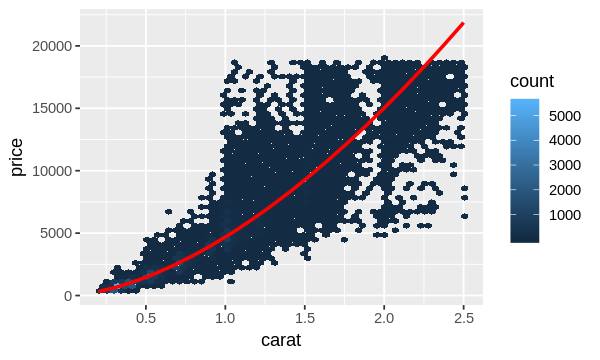

In [38]:
## Neues Modell auf transformierten Daten
mod_diamond <- lm(lprice ~ lcarat, data = diamonds2)

# Vorhersage und Rücktransformation für originalen Plot
grid <- diamonds2 %>%
  data_grid(carat = seq_range(carat, 20)) %>%
  mutate(lcarat = log2(carat)) %>%
  add_predictions(mod_diamond, "lprice") %>%
  mutate(price = 2 ^ lprice)

ggplot(diamonds2, aes(carat, price)) +
  geom_hex(bins = 50) +
  geom_line(data = grid, color = "red", size = 1)

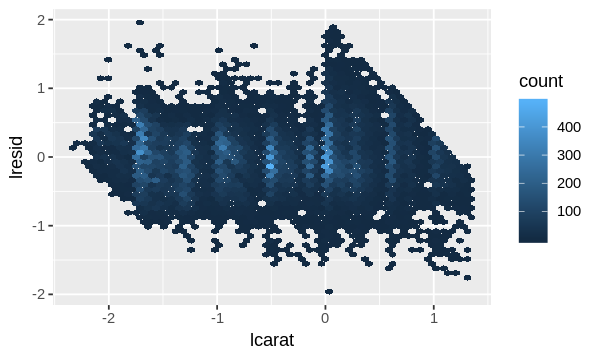

In [39]:
## Residuen haben nun keinen linearen Trend mehr
diamonds2 <- diamonds2 %>%
  add_residuals(mod_diamond, "lresid")

ggplot(diamonds2, aes(lcarat, lresid)) +
  geom_hex(bins = 50)


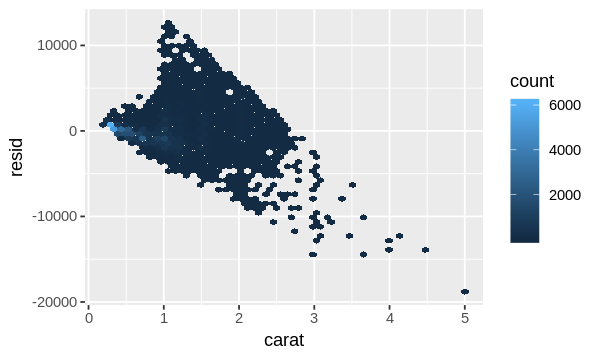

In [14]:
## Versus altes Modell
mod_diamond_normal <- lm(price ~ carat, data = diamonds)
diamonds <- diamonds %>%
  add_residuals(mod_diamond_normal, "resid")
ggplot(diamonds, aes(carat, resid)) +
  geom_hex(bins = 50)

In [18]:
head(diamonds2)

carat,cut,color,clarity,depth,table,price,x,y,z,resid,lprice,lcarat
<dbl>,<ord>,<ord>,<ord>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.23,Ideal,E,SI2,61.5,55,326,3.95,3.98,2.43,798.3827,8.348728,-2.120294
0.21,Premium,E,SI1,59.8,61,326,3.89,3.84,2.31,953.5112,8.348728,-2.251539
0.23,Good,E,VS1,56.9,65,327,4.05,4.07,2.31,799.3827,8.353147,-2.120294
0.29,Premium,I,VS2,62.4,58,334,4.20,4.23,2.63,340.9972,8.383704,-1.785875
0.31,Good,J,SI2,63.3,58,335,4.34,4.35,2.75,186.8686,8.388017,-1.689660
0.24,Very Good,J,VVS2,62.8,57,336,3.94,3.96,2.48,730.8184,8.392317,-2.058894


In [24]:
#### NACH RAUSSEPARIEREN DES CONFOUNDERS!!!!
# durch Verwendung der Residuen statt Price

#ggplot(diamonds2, aes(cut, lresid)) + geom_boxplot()
options(repr.plot.width=5, repr.plot.height=3)
p1 <- ggplot(diamonds2, aes(color, lresid)) + geom_boxplot()
p2 <- ggplot(diamonds2, aes(clarity, lresid)) + geom_boxplot()
grid.arrange(p1, p2, ncol=2)

# => Nachdem Effekt des Confounders entfernt
#    sehen Beziehungen wie erwartet aus

##### INTERPREATION der y-Achse = Residuen
# Was sagen die Residuen aus und wie skaliert? 
#
# Residual = 1 bedeutet, dass lpric e1 unit geringer war als die
#                        Vorhersage, welche nur auf Gewicht basierte 
# 2^(-1) = 1/2 => also Punkte mit 1 sind das halbe des erwarteten Preis 
# und Residuen mit dem Wert 1 sind das doppelte des vorhergesagten Preis

ERROR: Error in ggplot(diamonds2, aes(color, lresid)): object 'diamonds2' not found


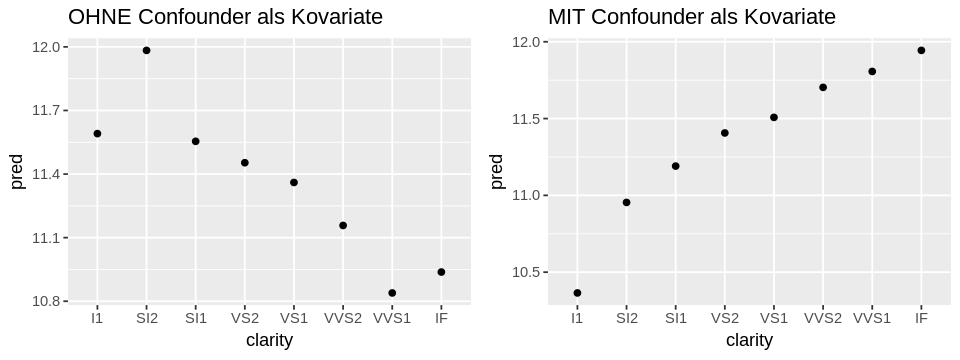

In [39]:
### EFFEKT DES CONFOUNDER IM KOMPLEXEN MODELL 
# => vs einfach nur die Mittelwerte einer Variable bzgl. Targets zu betrachten

# Modell mit & ohne einbezogenem Confounder - lcarat
mod_diamond2 <- lm(lprice ~ lcarat + color + cut + clarity, data = diamonds2)
mod_diamond2_without_confounder <- lm(lprice ~ color + cut + clarity, data = diamonds2)


## VISUALISIEREN DER PREDICTION ==> MIT UND OHNE CONFOUNDER ALS PRÄDIKATOR
# PROBLEM: mehrere Variablen schwer zu visualiseren
# => da unabhängig, können sie einzeln untersucht werden

#### Clarity

## Wenn Confounder NICHT als Kovariate drin ist: 
grid <- diamonds2 %>%
  data_grid(clarity, .model = mod_diamond2_without_confounder) %>%
  add_predictions(mod_diamond2_without_confounder)

p1 <- ggplot(grid, aes(clarity, pred)) +
    geom_point() + 
    ggtitle('OHNE Confounder als Kovariate')

## Wenn Confounder als Kovariate MIT DRIN ist: 
grid <- diamonds2 %>%
  data_grid(clarity, .model = mod_diamond2) %>%
  add_predictions(mod_diamond2)

p2 <- ggplot(grid, aes(clarity, pred)) +
    geom_point() +
    ggtitle('MIT Confounder als Kovariate')

options(repr.plot.width=8, repr.plot.height=3)
grid.arrange(p1, p2, ncol=2)

price,pred,carat,cut,color,clarity,depth,table,x,y,z
<int>,<dbl>,<dbl>,<ord>,<ord>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1013,264,0.25,Fair,F,SI2,54.4,64,4.30,4.23,2.32
1186,284,0.25,Premium,G,SI2,59.0,60,5.33,5.28,3.12
1186,284,0.25,Premium,G,SI2,58.8,60,5.33,5.28,3.12
1262,2644,1.03,Fair,E,I1,78.2,54,5.72,5.59,4.42
1415,639,0.35,Fair,G,VS2,65.9,54,5.57,5.53,3.66
1415,639,0.35,Fair,G,VS2,65.9,54,5.57,5.53,3.66
1715,576,0.32,Fair,F,VS2,59.6,60,4.42,4.34,2.61
1776,412,0.29,Fair,F,SI1,55.8,60,4.48,4.41,2.48
2160,314,0.34,Fair,F,I1,55.8,62,4.72,4.60,2.60


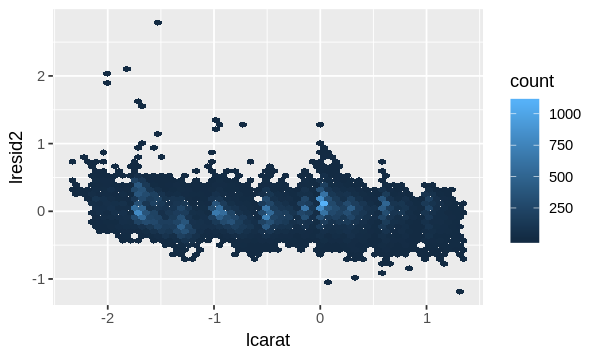

In [25]:
## RESIDUEN & AUSREISSER
diamonds2 <- diamonds2 %>%
  add_residuals(mod_diamond2, "lresid2")
ggplot(diamonds2, aes(lcarat, lresid2)) +
  geom_hex(bins = 50)
# => besser, aber immernoch einzelne Ausreisse => betrachten!

## Untersuchen der Ausreisser / schlecht erklärbaren Punkt
diamonds2 %>%
filter(abs(lresid2) > 1) %>%
  add_predictions(mod_diamond2) %>%
  mutate(pred = round(2 ^ pred)) %>%
  select(price, pred, carat:table, x:z) %>%
  arrange(price)